In [1]:
import gym_duckietown
import matplotlib.pyplot as plt
import numpy as np

from gym_duckietown.simulator import Simulator
from IPython import display as ipythondisplay

from utils import get_trajectory, get_position, my_odometry

DEBUG:commons:version: 6.2.4 *
DEBUG:typing:version: 6.2.3
DEBUG:duckietown_world:duckietown-world version 6.2.38 path /home/giulio/prog/.virtualenvs/RACE/lib/python3.8/site-packages
DEBUG:geometry:PyGeometry-z6 version 2.1.4 path /home/giulio/prog/.virtualenvs/RACE/lib/python3.8/site-packages
DEBUG:aido_schemas:aido-protocols version 6.0.59 path /home/giulio/prog/.virtualenvs/RACE/lib/python3.8/site-packages
DEBUG:nodes:version 6.2.13 path /home/giulio/prog/.virtualenvs/RACE/lib/python3.8/site-packages pyparsing 3.0.6
DEBUG:gym-duckietown:gym-duckietown version 6.1.30 path /home/giulio/prog/.virtualenvs/RACE/lib/python3.8/site-packages



{'audio': ('xaudio2', 'directsound', 'openal', 'pulse', 'silent'), 'debug_font': False, 'debug_gl': True, 'debug_gl_trace': False, 'debug_gl_trace_args': False, 'debug_graphics_batch': False, 'debug_lib': False, 'debug_media': False, 'debug_texture': False, 'debug_trace': False, 'debug_trace_args': False, 'debug_trace_depth': 1, 'debug_trace_flush': True, 'debug_win32': False, 'debug_x11': False, 'graphics_vbo': True, 'shadow_window': True, 'vsync': None, 'xsync': True, 'xlib_fullscreen_override_redirect': False, 'darwin_cocoa': True, 'search_local_libs': True, 'advanced_font_features': False, 'headless': False, 'headless_device': 0}


In [2]:
plt.rcParams['figure.figsize'] = [7, 7]

In [3]:
#gym_duckietown is very chatty
import logging
gym_duckietown.logger.setLevel(logging.WARNING)

In [4]:
env = Simulator("small_loop",
    full_transparency=True,
    domain_rand=False,
    user_tile_start=[1,0],
    seed=42,
    max_steps=float("inf"),
)

INFO:duckietown_world: data: /home/giulio/prog/.virtualenvs/RACE/lib/python3.8/site-packages/duckietown_world/data


In [5]:
env.unwrapped.start_pose = [[0.11699990272521976, 0, 0.41029359288296474], 0]

In [6]:
env.reset()
traj = get_trajectory(env)

In [7]:
traj[:10]

array([[1.47224186, 0.89882168],
       [1.46327478, 0.99399287],
       [1.46667284, 1.09337466],
       [1.47114545, 1.19275645],
       [1.47026898, 1.28107248],
       [1.44334587, 1.36818113],
       [1.39329816, 1.42978918],
       [1.32102126, 1.4597663 ],
       [1.24019591, 1.4699859 ],
       [1.14303777, 1.47681769]])

In [8]:
pose = get_position(env)
pose

Position(x=0.7019999, y=1.34470641, theta=0.0)

In [9]:
from scipy import spatial

In [10]:
distance,index = spatial.KDTree(traj).query([pose.x, pose.y])

In [11]:
traj[index]

array([0.72770678, 1.47150851])

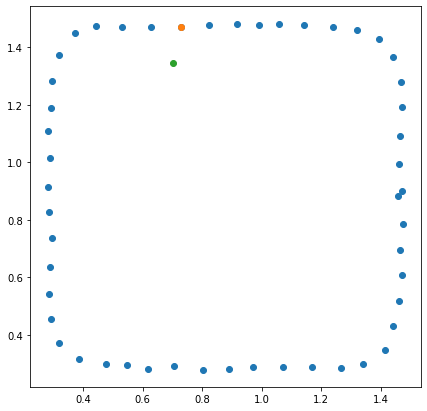

In [12]:
# Rotate the trajectory so that the agent is facing the same direction as the trajectory
plt.scatter(*traj.T)
plt.scatter(*traj[index])
plt.scatter(pose.x, pose.y)

In [13]:
from scipy.optimize import minimize

In [14]:
delta_time = 1.0 / env.frame_rate

def loss(x, pose, trajectory, index, last_actions, phi, env):
    env.reset()
    val = 0
    x = x.reshape(-1, 2)
    p1 = pose
    v0, w0 = 0, 0
    # To consider delay
    for i, el in enumerate(np.concatenate((last_actions, x))):
        p1, v0, w0 = my_odometry(el, p1.x, p1.y, p1.theta, v0=v0, w0=w0, dt=0.033)
        val += (phi**i)*((trajectory[index][0]-p1.x)**2 + (trajectory[index][1]-p1.y)**2)
    return val/len(x)

NB There is a delay of 0.15s (line 750)

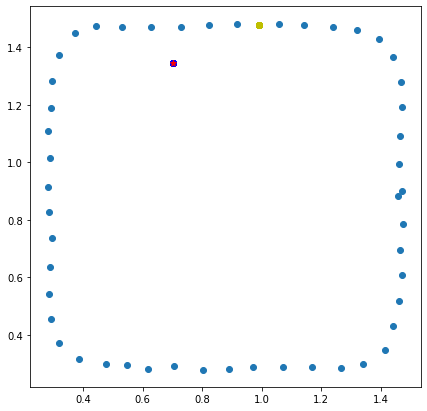

KeyboardInterrupt: 

In [19]:
horizon_len = 10
simulation_len = 30

delay = round(0.15/delta_time)
delay = 1
phi = 1

horizon_len = horizon_len * 2

bnds = list(((-1, 1) for _ in range(horizon_len)))

env.reset()
pose = get_position(env)
distance,index = spatial.KDTree(traj).query([pose.x, pose.y])
index = index - 3
plt.scatter(*traj.T)
actions = [[0,0] for _ in range(delay)]
loss_val = []
odoms = [pose]
poses = []
v0, w0, = 0, 0
env.reset()
for action in range(simulation_len):
    x0 = np.random.standard_normal(horizon_len)
    res = minimize(loss, x0, args=(pose, traj, index, np.array(actions[-delay:]), phi, env), method="L-BFGS-B", bounds=bnds)
    loss_val.append(res.fun)
    action = res.x[:2]
    obs, reward, done, info = env.step(action)
    if reward == -1000:
        print("Collision")
        break
    # Test odometry
    p, v0, w0 = my_odometry(action, odoms[-1].x, odoms[-1].y, odoms[-1].theta, v0=v0, w0=w0, dt=0.033)
    odoms.append(p)
    try:
        pose = get_position(env)
    except ValueError:
        print(env.cartesian_from_weird(env.cur_pos, env.cur_angle))
        break
    poses.append(pose)
    # print(loss(np.array([0,1]*int(horizon_len/2)).reshape(-1), pose, traj, index))
    plt.scatter(*traj[index], c='y')
    plt.scatter(pose.x, pose.y, marker="o", c="b")
    # Test odometry
    o = get_position(env)
    plt.scatter(o.x, o.y, marker="*", c="r")
    # plt.scatter(p.x, p.y, marker="*", c="r")
    # plt.imshow(obs)
    ipythondisplay.clear_output(wait=True)
    ipythondisplay.display(plt.gcf())
    # index = index-1
    if index < 0:
        index = traj.shape[0]-1

In [ ]:
import optuna

In [ ]:
def objective(trial):
    horizon_len = trial.suggest_int('horizon_len', 1, 20)
    delay = trial.suggest_int('delay', 1, 15)
    # phi = trial.suggest_float('phi', 0, 1)
    phi = 1
    simulation_len = 80
    horizon_len = horizon_len * 2

    bnds = list(((-1, 1) for _ in range(horizon_len)))

    env.reset()
    pose = get_position(env)
    distance,index = spatial.KDTree(traj).query([pose.x, pose.y])
    index = index - 3
    plt.scatter(*traj.T)
    actions = [[0,0] for _ in range(delay)]
    loss_val = []
    for _ in range(simulation_len):
        x0 = np.random.standard_normal(horizon_len)
        res = minimize(loss, x0, args=(pose, traj, index, np.array(actions[-delay:]), phi), method="L-BFGS-B", bounds=bnds)
        loss_val.append(res.fun)
        action = res.x[:2]
        actions.append(action)
        obs, reward, done, info = env.step(action)
        if reward == -1000:
            print("Collision")
            return 1000
        try:
            pose = get_position(env)
        except ValueError:
            print(env.cartesian_from_weird(env.cur_pos, env.cur_angle))
            return 1000
        if index < 0:
            index = traj.shape[0]-1
    return sum(loss_val)

[I 2021-12-31 20:51:35,457] A new study created in memory with name: no-name-3678be12-3519-4370-b50a-8f25f86398bc
[I 2021-12-31 20:53:37,070] Trial 0 finished with value: 1000.0 and parameters: {'horizon_len': 19, 'delay': 6}. Best is trial 0 with value: 1000.0.


[[ 0.20133687  0.97952206  0.782505  ]
 [-0.97952206  0.20133687  1.34341853]
 [ 0.          0.          1.        ]]


[I 2021-12-31 20:58:51,081] Trial 1 finished with value: 8.315930443281752 and parameters: {'horizon_len': 20, 'delay': 15}. Best is trial 1 with value: 8.315930443281752.
[I 2021-12-31 20:59:44,156] Trial 2 finished with value: 1000.0 and parameters: {'horizon_len': 12, 'delay': 7}. Best is trial 1 with value: 8.315930443281752.


[[ 0.28335052  0.95901641  0.843942  ]
 [-0.95901641  0.28335052  1.35135658]
 [ 0.          0.          1.        ]]


[I 2021-12-31 21:03:08,536] Trial 3 finished with value: 5.471766130479739 and parameters: {'horizon_len': 19, 'delay': 5}. Best is trial 3 with value: 5.471766130479739.
[I 2021-12-31 21:06:34,454] Trial 4 finished with value: 2.6792359915269994 and parameters: {'horizon_len': 20, 'delay': 2}. Best is trial 4 with value: 2.6792359915269994.
[I 2021-12-31 21:06:40,087] Trial 5 finished with value: 3.084336377238914 and parameters: {'horizon_len': 3, 'delay': 1}. Best is trial 4 with value: 2.6792359915269994.
[I 2021-12-31 21:07:32,121] Trial 6 finished with value: 1000.0 and parameters: {'horizon_len': 13, 'delay': 6}. Best is trial 4 with value: 2.6792359915269994.


[[ 0.89704244 -0.44194441  0.843486  ]
 [ 0.44194441  0.89704244  1.30617374]
 [ 0.          0.          1.        ]]


[I 2021-12-31 21:08:59,060] Trial 7 finished with value: 5.8824530581379735 and parameters: {'horizon_len': 13, 'delay': 8}. Best is trial 4 with value: 2.6792359915269994.
[I 2021-12-31 21:09:57,147] Trial 8 finished with value: 1000.0 and parameters: {'horizon_len': 13, 'delay': 14}. Best is trial 4 with value: 2.6792359915269994.


[[ 0.40956748  0.91227983  0.822527  ]
 [-0.91227983  0.40956748  1.32918237]
 [ 0.          0.          1.        ]]


[I 2021-12-31 21:12:27,725] Trial 9 finished with value: 5.602531072695301 and parameters: {'horizon_len': 17, 'delay': 12}. Best is trial 4 with value: 2.6792359915269994.
[I 2021-12-31 21:12:46,020] Trial 10 finished with value: 2.779522070523045 and parameters: {'horizon_len': 7, 'delay': 2}. Best is trial 4 with value: 2.6792359915269994.
[I 2021-12-31 21:12:53,199] Trial 11 finished with value: 1000.0 and parameters: {'horizon_len': 5, 'delay': 1}. Best is trial 4 with value: 2.6792359915269994.


[[ 0.84473491 -0.53518495  1.0348    ]
 [ 0.53518495  0.84473491  1.33074528]
 [ 0.          0.          1.        ]]


[I 2021-12-31 21:12:57,148] Trial 12 finished with value: 1000.0 and parameters: {'horizon_len': 7, 'delay': 3}. Best is trial 4 with value: 2.6792359915269994.


[[ 0.99470808 -0.10274163  0.936537  ]
 [ 0.10274163  0.99470808  1.34789261]
 [ 0.          0.          1.        ]]


[I 2021-12-31 21:13:01,447] Trial 13 finished with value: 1000.0 and parameters: {'horizon_len': 8, 'delay': 3}. Best is trial 4 with value: 2.6792359915269994.


[[ 0.99992613 -0.01215426  0.852011  ]
 [ 0.01215426  0.99992613  1.34486744]
 [ 0.          0.          1.        ]]


[I 2021-12-31 21:13:31,990] Trial 14 finished with value: 1000.0 and parameters: {'horizon_len': 9, 'delay': 11}. Best is trial 4 with value: 2.6792359915269994.


[[ 0.61820823  0.78601436  0.890371  ]
 [-0.78601436  0.61820823  1.31855268]
 [ 0.          0.          1.        ]]


[I 2021-12-31 21:13:35,598] Trial 15 finished with value: 10.728687048778 and parameters: {'horizon_len': 1, 'delay': 3}. Best is trial 4 with value: 2.6792359915269994.
[I 2021-12-31 21:15:01,422] Trial 16 finished with value: 1000.0 and parameters: {'horizon_len': 15, 'delay': 4}. Best is trial 4 with value: 2.6792359915269994.


Collision


[I 2021-12-31 21:15:34,727] Trial 17 finished with value: 7.901184354441537 and parameters: {'horizon_len': 10, 'delay': 10}. Best is trial 4 with value: 2.6792359915269994.
[I 2021-12-31 21:15:36,078] Trial 18 finished with value: 1000.0 and parameters: {'horizon_len': 6, 'delay': 1}. Best is trial 4 with value: 2.6792359915269994.


[[ 0.94152776 -0.33693543  1.049592  ]
 [ 0.33693543  0.94152776  1.36071593]
 [ 0.          0.          1.        ]]


[I 2021-12-31 21:16:31,290] Trial 19 finished with value: 5.787761080806382 and parameters: {'horizon_len': 16, 'delay': 8}. Best is trial 4 with value: 2.6792359915269994.
[I 2021-12-31 21:16:34,628] Trial 20 finished with value: 8.030479264500567 and parameters: {'horizon_len': 4, 'delay': 2}. Best is trial 4 with value: 2.6792359915269994.
[I 2021-12-31 21:16:35,283] Trial 21 finished with value: 1000.0 and parameters: {'horizon_len': 2, 'delay': 1}. Best is trial 4 with value: 2.6792359915269994.


[[ 0.96223901 -0.27220597  1.125978  ]
 [ 0.27220597  0.96223901  1.35753719]
 [ 0.          0.          1.        ]]


[I 2021-12-31 21:16:36,245] Trial 22 finished with value: 1000.0 and parameters: {'horizon_len': 3, 'delay': 4}. Best is trial 4 with value: 2.6792359915269994.


[[ 0.95887187 -0.28383929  1.086272  ]
 [ 0.28383929  0.95887187  1.35989635]
 [ 0.          0.          1.        ]]


[I 2021-12-31 21:16:39,643] Trial 23 finished with value: 3.490673441532369 and parameters: {'horizon_len': 5, 'delay': 2}. Best is trial 4 with value: 2.6792359915269994.
[I 2021-12-31 21:16:46,012] Trial 24 finished with value: 1000.0 and parameters: {'horizon_len': 7, 'delay': 5}. Best is trial 4 with value: 2.6792359915269994.


[[ 0.59081906  0.80680409  0.95334   ]
 [-0.80680409  0.59081906  1.36881385]
 [ 0.          0.          1.        ]]


[I 2021-12-31 21:16:48,112] Trial 25 finished with value: 1000.0 and parameters: {'horizon_len': 3, 'delay': 2}. Best is trial 4 with value: 2.6792359915269994.


[[ 0.89834551 -0.43928959  1.094988  ]
 [ 0.43928959  0.89834551  1.37151103]
 [ 0.          0.          1.        ]]


[I 2021-12-31 21:16:54,545] Trial 26 finished with value: 1000.0 and parameters: {'horizon_len': 10, 'delay': 4}. Best is trial 4 with value: 2.6792359915269994.


[[ 0.37084212  0.92869592  0.94963   ]
 [-0.92869592  0.37084212  1.30241602]
 [ 0.          0.          1.        ]]


[I 2021-12-31 21:16:55,675] Trial 27 finished with value: 1000.0 and parameters: {'horizon_len': 1, 'delay': 1}. Best is trial 4 with value: 2.6792359915269994.


[[ 0.96978559  0.24395881  1.23382   ]
 [-0.24395881  0.96978559  1.35037542]
 [ 0.          0.          1.        ]]


[I 2021-12-31 21:17:05,420] Trial 28 finished with value: 1000.0 and parameters: {'horizon_len': 8, 'delay': 3}. Best is trial 4 with value: 2.6792359915269994.


Collision


[I 2021-12-31 21:17:10,407] Trial 29 finished with value: 3.422381200401133 and parameters: {'horizon_len': 5, 'delay': 6}. Best is trial 4 with value: 2.6792359915269994.
[I 2021-12-31 21:17:29,620] Trial 30 finished with value: 4.1467673498659465 and parameters: {'horizon_len': 11, 'delay': 5}. Best is trial 4 with value: 2.6792359915269994.
[I 2021-12-31 21:17:34,629] Trial 31 finished with value: 3.635864674007367 and parameters: {'horizon_len': 5, 'delay': 6}. Best is trial 4 with value: 2.6792359915269994.
[I 2021-12-31 21:17:36,552] Trial 32 finished with value: 4.949898471720773 and parameters: {'horizon_len': 3, 'delay': 2}. Best is trial 4 with value: 2.6792359915269994.
[I 2021-12-31 21:19:26,808] Trial 33 finished with value: 5.966341336258483 and parameters: {'horizon_len': 20, 'delay': 9}. Best is trial 4 with value: 2.6792359915269994.
[I 2021-12-31 21:19:33,455] Trial 34 finished with value: 2.9844778330595276 and parameters: {'horizon_len': 6, 'delay': 4}. Best is tria

[[ 0.99464033 -0.10339547  0.820095  ]
 [ 0.10339547  0.99464033  1.34933541]
 [ 0.          0.          1.        ]]


[I 2021-12-31 21:20:12,476] Trial 39 finished with value: 1.8905955853613028 and parameters: {'horizon_len': 9, 'delay': 2}. Best is trial 39 with value: 1.8905955853613028.
[I 2021-12-31 21:20:20,348] Trial 40 finished with value: 1000.0 and parameters: {'horizon_len': 12, 'delay': 15}. Best is trial 39 with value: 1.8905955853613028.


[[ 0.91205848  0.41006014  0.839053  ]
 [-0.41006014  0.91205848  1.34029096]
 [ 0.          0.          1.        ]]


[I 2021-12-31 21:20:31,639] Trial 41 finished with value: 1.7183622952368984 and parameters: {'horizon_len': 9, 'delay': 2}. Best is trial 41 with value: 1.7183622952368984.
[I 2021-12-31 21:20:42,734] Trial 42 finished with value: 1000.0 and parameters: {'horizon_len': 9, 'delay': 3}. Best is trial 41 with value: 1.7183622952368984.


[[ 0.98850009  0.15122028  0.96085   ]
 [-0.15122028  0.98850009  1.36978544]
 [ 0.          0.          1.        ]]


[I 2021-12-31 21:21:35,802] Trial 43 finished with value: 3.9857937432729114 and parameters: {'horizon_len': 18, 'delay': 2}. Best is trial 41 with value: 1.7183622952368984.
[I 2021-12-31 21:21:51,224] Trial 44 finished with value: 1000.0 and parameters: {'horizon_len': 14, 'delay': 1}. Best is trial 41 with value: 1.7183622952368984.


[[ 0.93622248  0.35140783  0.779029  ]
 [-0.35140783  0.93622248  1.34008326]
 [ 0.          0.          1.        ]]


[I 2021-12-31 21:21:55,746] Trial 45 finished with value: 1000.0 and parameters: {'horizon_len': 9, 'delay': 3}. Best is trial 41 with value: 1.7183622952368984.


[[ 0.99975534  0.02211921  0.973982  ]
 [-0.02211921  0.99975534  1.35316786]
 [ 0.          0.          1.        ]]


[I 2021-12-31 21:22:14,659] Trial 46 finished with value: 1.738649680228747 and parameters: {'horizon_len': 12, 'delay': 1}. Best is trial 41 with value: 1.7183622952368984.
[I 2021-12-31 21:22:22,332] Trial 47 finished with value: 1.5490904499926335 and parameters: {'horizon_len': 8, 'delay': 1}. Best is trial 47 with value: 1.5490904499926335.
[I 2021-12-31 21:22:43,309] Trial 48 finished with value: 1.7309379415863966 and parameters: {'horizon_len': 12, 'delay': 1}. Best is trial 47 with value: 1.5490904499926335.
[I 2021-12-31 21:22:59,622] Trial 49 finished with value: 1000.0 and parameters: {'horizon_len': 12, 'delay': 1}. Best is trial 47 with value: 1.5490904499926335.


[[ 0.27602166 -0.96115142  0.972317  ]
 [ 0.96115142  0.27602166  1.27150746]
 [ 0.          0.          1.        ]]


[I 2021-12-31 21:23:04,608] Trial 50 finished with value: 1000.0 and parameters: {'horizon_len': 13, 'delay': 13}. Best is trial 47 with value: 1.5490904499926335.


[[ 0.99931146 -0.03710272  0.738642  ]
 [ 0.03710272  0.99931146  1.34543963]
 [ 0.          0.          1.        ]]


[I 2021-12-31 21:23:10,272] Trial 51 finished with value: 1000.0 and parameters: {'horizon_len': 8, 'delay': 1}. Best is trial 47 with value: 1.5490904499926335.


[[ 0.83612675 -0.54853629  0.999769  ]
 [ 0.54853629  0.83612675  1.37417091]
 [ 0.          0.          1.        ]]


[I 2021-12-31 21:23:24,601] Trial 52 finished with value: 1000.0 and parameters: {'horizon_len': 11, 'delay': 2}. Best is trial 47 with value: 1.5490904499926335.


[[ 0.89508444  0.44589668  0.958582  ]
 [-0.44589668  0.89508444  1.28945948]
 [ 0.          0.          1.        ]]


[I 2021-12-31 21:23:39,178] Trial 53 finished with value: 3.124253631407022 and parameters: {'horizon_len': 10, 'delay': 3}. Best is trial 47 with value: 1.5490904499926335.
[I 2021-12-31 21:24:08,173] Trial 54 finished with value: 4.107084456162096 and parameters: {'horizon_len': 14, 'delay': 1}. Best is trial 47 with value: 1.5490904499926335.
[I 2021-12-31 21:24:10,111] Trial 55 finished with value: 1000.0 and parameters: {'horizon_len': 12, 'delay': 2}. Best is trial 47 with value: 1.5490904499926335.


[[ 0.99913297 -0.04163301  0.781352  ]
 [ 0.04163301  0.99913297  1.34635377]
 [ 0.          0.          1.        ]]


[I 2021-12-31 21:24:18,479] Trial 56 finished with value: 1.848946384419308 and parameters: {'horizon_len': 8, 'delay': 1}. Best is trial 47 with value: 1.5490904499926335.
[I 2021-12-31 21:24:23,663] Trial 57 finished with value: 1000.0 and parameters: {'horizon_len': 8, 'delay': 1}. Best is trial 47 with value: 1.5490904499926335.


[[ 0.86456847 -0.50251503  0.970646  ]
 [ 0.50251503  0.86456847  1.32484048]
 [ 0.          0.          1.        ]]


[I 2021-12-31 21:24:37,222] Trial 58 finished with value: 1000.0 and parameters: {'horizon_len': 10, 'delay': 3}. Best is trial 47 with value: 1.5490904499926335.


[[-0.73849131  0.67426299  0.980724  ]
 [-0.67426299 -0.73849131  1.30242431]
 [ 0.          0.          1.        ]]


[I 2021-12-31 21:24:50,632] Trial 59 finished with value: 1000.0 and parameters: {'horizon_len': 9, 'delay': 5}. Best is trial 47 with value: 1.5490904499926335.


[[ 0.87886988  0.47706156  0.90886   ]
 [-0.47706156  0.87886988  1.40475606]
 [ 0.          0.          1.        ]]


[I 2021-12-31 21:24:59,818] Trial 60 finished with value: 1000.0 and parameters: {'horizon_len': 14, 'delay': 1}. Best is trial 47 with value: 1.5490904499926335.


[[ 0.89563855  0.44478263  0.766001  ]
 [-0.44478263  0.89563855  1.34097059]
 [ 0.          0.          1.        ]]


[I 2021-12-31 21:25:04,102] Trial 61 finished with value: 2.4699594855964233 and parameters: {'horizon_len': 6, 'delay': 2}. Best is trial 47 with value: 1.5490904499926335.
[I 2021-12-31 21:25:05,786] Trial 62 finished with value: 1000.0 and parameters: {'horizon_len': 7, 'delay': 1}. Best is trial 47 with value: 1.5490904499926335.


[[ 0.98596495 -0.16695244  0.988417  ]
 [ 0.16695244  0.98596495  1.35172777]
 [ 0.          0.          1.        ]]


[I 2021-12-31 21:25:15,576] Trial 63 finished with value: 2.348626157436488 and parameters: {'horizon_len': 8, 'delay': 3}. Best is trial 47 with value: 1.5490904499926335.
[I 2021-12-31 21:25:18,677] Trial 64 finished with value: 1000.0 and parameters: {'horizon_len': 11, 'delay': 2}. Best is trial 47 with value: 1.5490904499926335.


[[ 0.99378077  0.11135432  0.886518  ]
 [-0.11135432  0.99378077  1.34646272]
 [ 0.          0.          1.        ]]


[I 2021-12-31 21:25:27,676] Trial 65 finished with value: 1000.0 and parameters: {'horizon_len': 12, 'delay': 1}. Best is trial 47 with value: 1.5490904499926335.


[[ 0.81771458  0.57562389  0.922816  ]
 [-0.57562389  0.81771458  1.34784327]
 [ 0.          0.          1.        ]]


[I 2021-12-31 21:25:43,540] Trial 66 finished with value: 2.399763012288727 and parameters: {'horizon_len': 10, 'delay': 4}. Best is trial 47 with value: 1.5490904499926335.
[I 2021-12-31 21:25:47,138] Trial 67 finished with value: 1000.0 and parameters: {'horizon_len': 6, 'delay': 2}. Best is trial 47 with value: 1.5490904499926335.


[[ 0.92998492 -0.36759766  0.886699  ]
 [ 0.36759766  0.92998492  1.31281636]
 [ 0.          0.          1.        ]]


[I 2021-12-31 21:25:49,249] Trial 68 finished with value: 1000.0 and parameters: {'horizon_len': 9, 'delay': 1}. Best is trial 47 with value: 1.5490904499926335.


[[ 0.99492891 -0.10058065  0.917686  ]
 [ 0.10058065  0.99492891  1.34813599]
 [ 0.          0.          1.        ]]


[I 2021-12-31 21:25:56,722] Trial 69 finished with value: 2.252786020965919 and parameters: {'horizon_len': 7, 'delay': 3}. Best is trial 47 with value: 1.5490904499926335.
[I 2021-12-31 21:26:11,642] Trial 70 finished with value: 1000.0 and parameters: {'horizon_len': 13, 'delay': 2}. Best is trial 47 with value: 1.5490904499926335.


[[ 0.42329445  0.90599217  0.775359  ]
 [-0.90599217  0.42329445  1.40306235]
 [ 0.          0.          1.        ]]


[I 2021-12-31 21:26:18,154] Trial 71 finished with value: 2.3728891612834038 and parameters: {'horizon_len': 7, 'delay': 3}. Best is trial 47 with value: 1.5490904499926335.
[I 2021-12-31 21:26:21,490] Trial 72 finished with value: 1000.0 and parameters: {'horizon_len': 8, 'delay': 1}. Best is trial 47 with value: 1.5490904499926335.


[[ 0.84852462 -0.52915591  1.00135   ]
 [ 0.52915591  0.84852462  1.35872446]
 [ 0.          0.          1.        ]]


[I 2021-12-31 21:26:31,214] Trial 73 finished with value: 2.3437901893500377 and parameters: {'horizon_len': 8, 'delay': 2}. Best is trial 47 with value: 1.5490904499926335.
[I 2021-12-31 21:26:38,518] Trial 74 finished with value: 3.0156776985758578 and parameters: {'horizon_len': 7, 'delay': 2}. Best is trial 47 with value: 1.5490904499926335.
[I 2021-12-31 21:26:40,476] Trial 75 finished with value: 1000.0 and parameters: {'horizon_len': 6, 'delay': 3}. Best is trial 47 with value: 1.5490904499926335.


[[ 0.99823223 -0.05943411  1.028629  ]
 [ 0.05943411  0.99823223  1.35702154]
 [ 0.          0.          1.        ]]


[I 2021-12-31 21:26:42,245] Trial 76 finished with value: 1000.0 and parameters: {'horizon_len': 4, 'delay': 1}. Best is trial 47 with value: 1.5490904499926335.


[[ 0.63087473 -0.77588471  1.09651   ]
 [ 0.77588471  0.63087473  1.36272313]
 [ 0.          0.          1.        ]]


[I 2021-12-31 21:26:44,689] Trial 77 finished with value: 1000.0 and parameters: {'horizon_len': 10, 'delay': 7}. Best is trial 47 with value: 1.5490904499926335.


[[ 0.99748156 -0.07092623  0.794542  ]
 [ 0.07092623  0.99748156  1.34658778]
 [ 0.          0.          1.        ]]


[I 2021-12-31 21:26:55,901] Trial 78 finished with value: 1.4263769114725302 and parameters: {'horizon_len': 9, 'delay': 1}. Best is trial 78 with value: 1.4263769114725302.
[I 2021-12-31 21:26:57,576] Trial 79 finished with value: 1000.0 and parameters: {'horizon_len': 11, 'delay': 1}. Best is trial 78 with value: 1.4263769114725302.


[[ 9.99999768e-01 -6.80697645e-04  7.69839997e-01]
 [ 6.80697645e-04  9.99999768e-01  1.34471129e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]


[I 2021-12-31 21:27:09,521] Trial 80 finished with value: 1000.0 and parameters: {'horizon_len': 9, 'delay': 11}. Best is trial 78 with value: 1.4263769114725302.


[[ 0.75916942  0.65089307  0.860689  ]
 [-0.65089307  0.75916942  1.33184147]
 [ 0.          0.          1.        ]]


[I 2021-12-31 21:27:16,957] Trial 81 finished with value: 2.3746807230518354 and parameters: {'horizon_len': 7, 'delay': 2}. Best is trial 78 with value: 1.4263769114725302.
[I 2021-12-31 21:27:25,055] Trial 82 finished with value: 1.9474253879875931 and parameters: {'horizon_len': 8, 'delay': 1}. Best is trial 78 with value: 1.4263769114725302.
[I 2021-12-31 21:27:31,889] Trial 83 finished with value: 1000.0 and parameters: {'horizon_len': 8, 'delay': 1}. Best is trial 78 with value: 1.4263769114725302.


[[ 0.74698248  0.66484373  1.075973  ]
 [-0.66484373  0.74698248  1.38057923]
 [ 0.          0.          1.        ]]


[I 2021-12-31 21:27:41,599] Trial 84 finished with value: 1.5516184942119262 and parameters: {'horizon_len': 9, 'delay': 1}. Best is trial 78 with value: 1.4263769114725302.
[I 2021-12-31 21:27:45,980] Trial 85 finished with value: 1000.0 and parameters: {'horizon_len': 9, 'delay': 1}. Best is trial 78 with value: 1.4263769114725302.


[[ 0.93803477 -0.34654114  1.03604   ]
 [ 0.34654114  0.93803477  1.38057125]
 [ 0.          0.          1.        ]]


[I 2021-12-31 21:27:56,439] Trial 86 finished with value: 1000.0 and parameters: {'horizon_len': 10, 'delay': 1}. Best is trial 78 with value: 1.4263769114725302.


[[ 0.43207827  0.90183611  1.054237  ]
 [-0.90183611  0.43207827  1.34125272]
 [ 0.          0.          1.        ]]


[I 2021-12-31 21:28:06,769] Trial 87 finished with value: 1000.0 and parameters: {'horizon_len': 11, 'delay': 2}. Best is trial 78 with value: 1.4263769114725302.


[[ 0.51964936  0.85437962  0.939932  ]
 [-0.85437962  0.51964936  1.34638736]
 [ 0.          0.          1.        ]]


[I 2021-12-31 21:28:21,973] Trial 88 finished with value: 1.5837561979950878 and parameters: {'horizon_len': 10, 'delay': 1}. Best is trial 78 with value: 1.4263769114725302.
[I 2021-12-31 21:28:39,143] Trial 89 finished with value: 1.7858247156380915 and parameters: {'horizon_len': 10, 'delay': 2}. Best is trial 78 with value: 1.4263769114725302.
[I 2021-12-31 21:28:58,018] Trial 90 finished with value: 1.9311158697900943 and parameters: {'horizon_len': 12, 'delay': 1}. Best is trial 78 with value: 1.4263769114725302.
[I 2021-12-31 21:29:11,414] Trial 91 finished with value: 2.0576802471092672 and parameters: {'horizon_len': 10, 'delay': 2}. Best is trial 78 with value: 1.4263769114725302.
[I 2021-12-31 21:29:21,785] Trial 92 finished with value: 1.3173522599073766 and parameters: {'horizon_len': 9, 'delay': 1}. Best is trial 92 with value: 1.3173522599073766.
[I 2021-12-31 21:29:35,837] Trial 93 finished with value: 1.5595553210167 and parameters: {'horizon_len': 10, 'delay': 1}. Bes

[[-0.39195347 -0.91998504  0.834332  ]
 [ 0.91998504 -0.39195347  1.34870245]
 [ 0.          0.          1.        ]]


[I 2021-12-31 21:30:00,217] Trial 95 finished with value: 1.7124394863457781 and parameters: {'horizon_len': 10, 'delay': 1}. Best is trial 92 with value: 1.3173522599073766.
[I 2021-12-31 21:30:03,686] Trial 96 finished with value: 1000.0 and parameters: {'horizon_len': 9, 'delay': 1}. Best is trial 92 with value: 1.3173522599073766.


[[ 0.93709837 -0.3490654   0.996977  ]
 [ 0.3490654   0.93709837  1.36276281]
 [ 0.          0.          1.        ]]


[I 2021-12-31 21:30:22,180] Trial 97 finished with value: 1000.0 and parameters: {'horizon_len': 12, 'delay': 1}. Best is trial 92 with value: 1.3173522599073766.


Collision


[I 2021-12-31 21:30:51,663] Trial 98 finished with value: 8.711032292952272 and parameters: {'horizon_len': 11, 'delay': 14}. Best is trial 92 with value: 1.3173522599073766.
[I 2021-12-31 21:31:07,519] Trial 99 finished with value: 1000.0 and parameters: {'horizon_len': 13, 'delay': 1}. Best is trial 92 with value: 1.3173522599073766.


[[ 0.11651748  0.99318864  0.770253  ]
 [-0.99318864  0.11651748  1.35338093]
 [ 0.          0.          1.        ]]


[I 2021-12-31 21:31:21,927] Trial 100 finished with value: 1.6820041534113994 and parameters: {'horizon_len': 10, 'delay': 2}. Best is trial 92 with value: 1.3173522599073766.
[I 2021-12-31 21:31:30,844] Trial 101 finished with value: 1000.0 and parameters: {'horizon_len': 10, 'delay': 2}. Best is trial 92 with value: 1.3173522599073766.


[[ 0.98476578  0.17388607  0.951365  ]
 [-0.17388607  0.98476578  1.34568224]
 [ 0.          0.          1.        ]]


[I 2021-12-31 21:31:40,943] Trial 102 finished with value: 1.3298484345422275 and parameters: {'horizon_len': 9, 'delay': 1}. Best is trial 92 with value: 1.3173522599073766.
[I 2021-12-31 21:31:52,872] Trial 103 finished with value: 1.7204734587484936 and parameters: {'horizon_len': 9, 'delay': 1}. Best is trial 92 with value: 1.3173522599073766.
[I 2021-12-31 21:31:56,644] Trial 104 finished with value: 1000.0 and parameters: {'horizon_len': 9, 'delay': 1}. Best is trial 92 with value: 1.3173522599073766.


[[ 0.98093718 -0.19432513  0.971871  ]
 [ 0.19432513  0.98093718  1.35534595]
 [ 0.          0.          1.        ]]


[I 2021-12-31 21:32:07,457] Trial 105 finished with value: 1.6489822566015362 and parameters: {'horizon_len': 9, 'delay': 2}. Best is trial 92 with value: 1.3173522599073766.
[I 2021-12-31 21:32:12,007] Trial 106 finished with value: 1000.0 and parameters: {'horizon_len': 10, 'delay': 3}. Best is trial 92 with value: 1.3173522599073766.


[[ 0.9626111   0.2708872   0.927604  ]
 [-0.2708872   0.9626111   1.34425175]
 [ 0.          0.          1.        ]]


[I 2021-12-31 21:32:21,447] Trial 107 finished with value: 1000.0 and parameters: {'horizon_len': 9, 'delay': 2}. Best is trial 92 with value: 1.3173522599073766.


[[ 0.5249199  -0.85115163  0.935284  ]
 [ 0.85115163  0.5249199   1.32896089]
 [ 0.          0.          1.        ]]


[I 2021-12-31 21:32:26,163] Trial 108 finished with value: 1000.0 and parameters: {'horizon_len': 8, 'delay': 2}. Best is trial 92 with value: 1.3173522599073766.


[[ 0.99857345 -0.05339541  1.083596  ]
 [ 0.05339541  0.99857345  1.36361327]
 [ 0.          0.          1.        ]]


[I 2021-12-31 21:32:33,875] Trial 109 finished with value: 1000.0 and parameters: {'horizon_len': 10, 'delay': 2}. Best is trial 92 with value: 1.3173522599073766.


[[ 0.99923552 -0.03909448  0.968502  ]
 [ 0.03909448  0.99923552  1.34607817]
 [ 0.          0.          1.        ]]


[I 2021-12-31 21:32:37,630] Trial 110 finished with value: 1000.0 and parameters: {'horizon_len': 9, 'delay': 1}. Best is trial 92 with value: 1.3173522599073766.


[[ 0.89528008 -0.44550373  1.011412  ]
 [ 0.44550373  0.89528008  1.36946133]
 [ 0.          0.          1.        ]]


[I 2021-12-31 21:32:51,330] Trial 111 finished with value: 1.615365394326711 and parameters: {'horizon_len': 9, 'delay': 1}. Best is trial 92 with value: 1.3173522599073766.
[I 2021-12-31 21:32:57,931] Trial 112 finished with value: 1000.0 and parameters: {'horizon_len': 8, 'delay': 1}. Best is trial 92 with value: 1.3173522599073766.


[[ 0.83223238  0.55442697  0.957435  ]
 [-0.55442697  0.83223238  1.35163365]
 [ 0.          0.          1.        ]]


[I 2021-12-31 21:33:13,852] Trial 113 finished with value: 1.5335493984059938 and parameters: {'horizon_len': 10, 'delay': 2}. Best is trial 92 with value: 1.3173522599073766.
[I 2021-12-31 21:33:27,865] Trial 114 finished with value: 1.7385033016799487 and parameters: {'horizon_len': 10, 'delay': 2}. Best is trial 92 with value: 1.3173522599073766.
[I 2021-12-31 21:33:45,179] Trial 115 finished with value: 1.891535758280613 and parameters: {'horizon_len': 11, 'delay': 1}. Best is trial 92 with value: 1.3173522599073766.
[I 2021-12-31 21:33:55,970] Trial 116 finished with value: 2.110430682308801 and parameters: {'horizon_len': 9, 'delay': 3}. Best is trial 92 with value: 1.3173522599073766.
[I 2021-12-31 21:34:09,500] Trial 117 finished with value: 1.4280913984162442 and parameters: {'horizon_len': 10, 'delay': 1}. Best is trial 92 with value: 1.3173522599073766.
[I 2021-12-31 21:34:14,053] Trial 118 finished with value: 1000.0 and parameters: {'horizon_len': 10, 'delay': 2}. Best is 

[[ 0.99686817  0.07908124  0.96752   ]
 [-0.07908124  0.99686817  1.34527257]
 [ 0.          0.          1.        ]]


[I 2021-12-31 21:34:25,249] Trial 119 finished with value: 1.6648262306549293 and parameters: {'horizon_len': 9, 'delay': 2}. Best is trial 92 with value: 1.3173522599073766.
[I 2021-12-31 21:34:28,968] Trial 120 finished with value: 1000.0 and parameters: {'horizon_len': 8, 'delay': 1}. Best is trial 92 with value: 1.3173522599073766.


[[ 0.96838493 -0.24946067  1.012038  ]
 [ 0.24946067  0.96838493  1.36204676]
 [ 0.          0.          1.        ]]


[I 2021-12-31 21:34:40,585] Trial 121 finished with value: 1.7307415845484173 and parameters: {'horizon_len': 9, 'delay': 2}. Best is trial 92 with value: 1.3173522599073766.
[I 2021-12-31 21:34:45,406] Trial 122 finished with value: 1000.0 and parameters: {'horizon_len': 9, 'delay': 2}. Best is trial 92 with value: 1.3173522599073766.


[[ 0.99439495  0.10572929  0.926326  ]
 [-0.10572929  0.99439495  1.35242088]
 [ 0.          0.          1.        ]]


[I 2021-12-31 21:34:48,005] Trial 123 finished with value: 1000.0 and parameters: {'horizon_len': 8, 'delay': 1}. Best is trial 92 with value: 1.3173522599073766.


[[ 0.9070145  -0.42109938  1.002331  ]
 [ 0.42109938  0.9070145   1.36372283]
 [ 0.          0.          1.        ]]


[I 2021-12-31 21:34:50,170] Trial 124 finished with value: 1000.0 and parameters: {'horizon_len': 11, 'delay': 2}. Best is trial 92 with value: 1.3173522599073766.


[[ 0.99977145 -0.02137871  0.799299  ]
 [ 0.02137871  0.99977145  1.34515337]
 [ 0.          0.          1.        ]]


[I 2021-12-31 21:35:01,297] Trial 125 finished with value: 1.5408930444702005 and parameters: {'horizon_len': 9, 'delay': 1}. Best is trial 92 with value: 1.3173522599073766.
[I 2021-12-31 21:35:11,136] Trial 126 finished with value: 1.7880575838947947 and parameters: {'horizon_len': 9, 'delay': 1}. Best is trial 92 with value: 1.3173522599073766.
[I 2021-12-31 21:35:16,048] Trial 127 finished with value: 1000.0 and parameters: {'horizon_len': 9, 'delay': 1}. Best is trial 92 with value: 1.3173522599073766.


[[ 0.91827251 -0.39594899  1.097515  ]
 [ 0.39594899  0.91827251  1.41637706]
 [ 0.          0.          1.        ]]


[I 2021-12-31 21:35:20,642] Trial 128 finished with value: 1000.0 and parameters: {'horizon_len': 8, 'delay': 1}. Best is trial 92 with value: 1.3173522599073766.


[[ 0.5903671  -0.80713486  1.031171  ]
 [ 0.80713486  0.5903671   1.37432502]
 [ 0.          0.          1.        ]]


[I 2021-12-31 21:35:30,012] Trial 129 finished with value: 1000.0 and parameters: {'horizon_len': 10, 'delay': 1}. Best is trial 92 with value: 1.3173522599073766.


[[ 0.96304484 -0.26934112  1.032268  ]
 [ 0.26934112  0.96304484  1.36197763]
 [ 0.          0.          1.        ]]


[I 2021-12-31 21:35:46,874] Trial 130 finished with value: 1000.0 and parameters: {'horizon_len': 11, 'delay': 1}. Best is trial 92 with value: 1.3173522599073766.


[[ 0.9677814  -0.25179191  0.904     ]
 [ 0.25179191  0.9677814   1.34733702]
 [ 0.          0.          1.        ]]


[I 2021-12-31 21:36:01,661] Trial 131 finished with value: 1.9656225537820162 and parameters: {'horizon_len': 10, 'delay': 2}. Best is trial 92 with value: 1.3173522599073766.
[I 2021-12-31 21:36:03,046] Trial 132 finished with value: 1000.0 and parameters: {'horizon_len': 9, 'delay': 2}. Best is trial 92 with value: 1.3173522599073766.


[[ 0.99999824 -0.00187447  0.817963  ]
 [ 0.00187447  0.99999824  1.34472195]
 [ 0.          0.          1.        ]]


[I 2021-12-31 21:36:06,005] Trial 133 finished with value: 1000.0 and parameters: {'horizon_len': 10, 'delay': 1}. Best is trial 92 with value: 1.3173522599073766.


[[ 0.99352929 -0.1135762   0.942954  ]
 [ 0.1135762   0.99352929  1.35327401]
 [ 0.          0.          1.        ]]


[I 2021-12-31 21:36:08,463] Trial 134 finished with value: 1000.0 and parameters: {'horizon_len': 9, 'delay': 3}. Best is trial 92 with value: 1.3173522599073766.


[[ 0.99739261 -0.07216633  0.920638  ]
 [ 0.07216633  0.99739261  1.34918283]
 [ 0.          0.          1.        ]]


[I 2021-12-31 21:36:11,692] Trial 135 finished with value: 1000.0 and parameters: {'horizon_len': 8, 'delay': 1}. Best is trial 92 with value: 1.3173522599073766.


[[ 0.89043598 -0.45510851  1.002508  ]
 [ 0.45510851  0.89043598  1.35950952]
 [ 0.          0.          1.        ]]


[I 2021-12-31 21:36:26,082] Trial 136 finished with value: 1.9440727054142874 and parameters: {'horizon_len': 10, 'delay': 2}. Best is trial 92 with value: 1.3173522599073766.
[I 2021-12-31 21:36:32,735] Trial 137 finished with value: 2.057285908324762 and parameters: {'horizon_len': 7, 'delay': 1}. Best is trial 92 with value: 1.3173522599073766.
[I 2021-12-31 21:36:38,432] Trial 138 finished with value: 1000.0 and parameters: {'horizon_len': 9, 'delay': 2}. Best is trial 92 with value: 1.3173522599073766.


[[ 0.99886685 -0.04759224  0.705546  ]
 [ 0.04759224  0.99886685  1.33623355]
 [ 0.          0.          1.        ]]


[I 2021-12-31 21:36:47,123] Trial 139 finished with value: 1.520121171765745 and parameters: {'horizon_len': 8, 'delay': 1}. Best is trial 92 with value: 1.3173522599073766.
[I 2021-12-31 21:36:50,442] Trial 140 finished with value: 1000.0 and parameters: {'horizon_len': 8, 'delay': 1}. Best is trial 92 with value: 1.3173522599073766.


[[ 0.87728287 -0.47997372  1.038206  ]
 [ 0.47997372  0.87728287  1.37503724]
 [ 0.          0.          1.        ]]


[I 2021-12-31 21:37:01,667] Trial 141 finished with value: 1.9221204235166596 and parameters: {'horizon_len': 9, 'delay': 1}. Best is trial 92 with value: 1.3173522599073766.
[I 2021-12-31 21:37:08,793] Trial 142 finished with value: 1000.0 and parameters: {'horizon_len': 10, 'delay': 1}. Best is trial 92 with value: 1.3173522599073766.


[[ 0.95818976 -0.2861335   0.935295  ]
 [ 0.2861335   0.95818976  1.35569906]
 [ 0.          0.          1.        ]]


[I 2021-12-31 21:37:17,717] Trial 143 finished with value: 2.7421587721604084 and parameters: {'horizon_len': 8, 'delay': 2}. Best is trial 92 with value: 1.3173522599073766.
[I 2021-12-31 21:37:22,794] Trial 144 finished with value: 1000.0 and parameters: {'horizon_len': 9, 'delay': 8}. Best is trial 92 with value: 1.3173522599073766.


[[ 0.99156534  0.12960779  0.866486  ]
 [-0.12960779  0.99156534  1.34658065]
 [ 0.          0.          1.        ]]


[I 2021-12-31 21:37:27,683] Trial 145 finished with value: 1000.0 and parameters: {'horizon_len': 10, 'delay': 1}. Best is trial 92 with value: 1.3173522599073766.


[[ 0.99641839  0.08456003  0.983472  ]
 [-0.08456003  0.99641839  1.35502312]
 [ 0.          0.          1.        ]]


[I 2021-12-31 21:37:29,790] Trial 146 finished with value: 1000.0 and parameters: {'horizon_len': 11, 'delay': 2}. Best is trial 92 with value: 1.3173522599073766.


[[ 0.99993833 -0.01110559  0.78417   ]
 [ 0.01110559  0.99993833  1.34489831]
 [ 0.          0.          1.        ]]


[I 2021-12-31 21:37:37,432] Trial 147 finished with value: 1.7552636117906881 and parameters: {'horizon_len': 8, 'delay': 1}. Best is trial 92 with value: 1.3173522599073766.
[I 2021-12-31 21:37:52,087] Trial 148 finished with value: 1.61466088967544 and parameters: {'horizon_len': 10, 'delay': 1}. Best is trial 92 with value: 1.3173522599073766.
[I 2021-12-31 21:37:59,155] Trial 149 finished with value: 2.1377954739476475 and parameters: {'horizon_len': 7, 'delay': 1}. Best is trial 92 with value: 1.3173522599073766.
[I 2021-12-31 21:38:10,202] Trial 150 finished with value: 1.6519695213063916 and parameters: {'horizon_len': 9, 'delay': 1}. Best is trial 92 with value: 1.3173522599073766.
[I 2021-12-31 21:38:19,759] Trial 151 finished with value: 1.620719457491479 and parameters: {'horizon_len': 9, 'delay': 1}. Best is trial 92 with value: 1.3173522599073766.
[I 2021-12-31 21:38:25,108] Trial 152 finished with value: 1000.0 and parameters: {'horizon_len': 9, 'delay': 1}. Best is trial

[[ 0.97791596  0.20899852  1.055197  ]
 [-0.20899852  0.97791596  1.38513584]
 [ 0.          0.          1.        ]]


[I 2021-12-31 21:38:32,174] Trial 153 finished with value: 1000.0 and parameters: {'horizon_len': 9, 'delay': 1}. Best is trial 92 with value: 1.3173522599073766.


[[ 0.99184739  0.12743134  1.028699  ]
 [-0.12743134  0.99184739  1.36660977]
 [ 0.          0.          1.        ]]


[I 2021-12-31 21:38:35,967] Trial 154 finished with value: 1000.0 and parameters: {'horizon_len': 10, 'delay': 1}. Best is trial 92 with value: 1.3173522599073766.


[[ 0.99554936 -0.09424156  0.9531    ]
 [ 0.09424156  0.99554936  1.35428619]
 [ 0.          0.          1.        ]]


[I 2021-12-31 21:38:43,049] Trial 155 finished with value: 1.5758624869243134 and parameters: {'horizon_len': 8, 'delay': 1}. Best is trial 92 with value: 1.3173522599073766.
[I 2021-12-31 21:38:51,730] Trial 156 finished with value: 2.0307473064821404 and parameters: {'horizon_len': 8, 'delay': 1}. Best is trial 92 with value: 1.3173522599073766.
[I 2021-12-31 21:38:59,607] Trial 157 finished with value: 1.5964711428991543 and parameters: {'horizon_len': 8, 'delay': 1}. Best is trial 92 with value: 1.3173522599073766.
[I 2021-12-31 21:39:02,581] Trial 158 finished with value: 1000.0 and parameters: {'horizon_len': 7, 'delay': 1}. Best is trial 92 with value: 1.3173522599073766.


[[ 0.82613546 -0.56347156  1.093572  ]
 [ 0.56347156  0.82613546  1.38630312]
 [ 0.          0.          1.        ]]


[I 2021-12-31 21:39:10,249] Trial 159 finished with value: 1.5942269668199431 and parameters: {'horizon_len': 8, 'delay': 1}. Best is trial 92 with value: 1.3173522599073766.
[I 2021-12-31 21:39:18,899] Trial 160 finished with value: 1.7638211124388876 and parameters: {'horizon_len': 8, 'delay': 1}. Best is trial 92 with value: 1.3173522599073766.
[I 2021-12-31 21:39:21,034] Trial 161 finished with value: 1000.0 and parameters: {'horizon_len': 7, 'delay': 1}. Best is trial 92 with value: 1.3173522599073766.


[[ 0.80028102 -0.59962512  1.059517  ]
 [ 0.59962512  0.80028102  1.37406805]
 [ 0.          0.          1.        ]]


[I 2021-12-31 21:39:28,334] Trial 162 finished with value: 1.7476242186632278 and parameters: {'horizon_len': 8, 'delay': 1}. Best is trial 92 with value: 1.3173522599073766.
[I 2021-12-31 21:39:30,689] Trial 163 finished with value: 1000.0 and parameters: {'horizon_len': 8, 'delay': 1}. Best is trial 92 with value: 1.3173522599073766.


[[ 0.98718919 -0.15955409  0.95022   ]
 [ 0.15955409  0.98718919  1.35000323]
 [ 0.          0.          1.        ]]


[I 2021-12-31 21:39:35,066] Trial 164 finished with value: 1000.0 and parameters: {'horizon_len': 8, 'delay': 1}. Best is trial 92 with value: 1.3173522599073766.


[[ 0.84450918 -0.53554108  1.012907  ]
 [ 0.53554108  0.84450918  1.36462669]
 [ 0.          0.          1.        ]]


[I 2021-12-31 21:39:43,149] Trial 165 finished with value: 1000.0 and parameters: {'horizon_len': 9, 'delay': 1}. Best is trial 92 with value: 1.3173522599073766.


[[-0.63126884 -0.77556408  0.982698  ]
 [ 0.77556408 -0.63126884  1.32451404]
 [ 0.          0.          1.        ]]


[I 2021-12-31 21:39:49,977] Trial 166 finished with value: 1000.0 and parameters: {'horizon_len': 10, 'delay': 1}. Best is trial 92 with value: 1.3173522599073766.


[[ 0.97133589  0.23771116  1.000446  ]
 [-0.23771116  0.97133589  1.35196045]
 [ 0.          0.          1.        ]]


[I 2021-12-31 21:39:52,752] Trial 167 finished with value: 1000.0 and parameters: {'horizon_len': 8, 'delay': 1}. Best is trial 92 with value: 1.3173522599073766.


[[ 0.83349686 -0.5525242   1.023192  ]
 [ 0.5525242   0.83349686  1.37576383]
 [ 0.          0.          1.        ]]


[I 2021-12-31 21:39:56,777] Trial 168 finished with value: 1000.0 and parameters: {'horizon_len': 10, 'delay': 1}. Best is trial 92 with value: 1.3173522599073766.


[[ 0.98966265 -0.14341494  0.989426  ]
 [ 0.14341494  0.98966265  1.35906275]
 [ 0.          0.          1.        ]]


[I 2021-12-31 21:40:10,640] Trial 169 finished with value: 1000.0 and parameters: {'horizon_len': 9, 'delay': 7}. Best is trial 92 with value: 1.3173522599073766.


[[ 0.90735056  0.42037479  0.881133  ]
 [-0.42037479  0.90735056  1.33507864]
 [ 0.          0.          1.        ]]


[I 2021-12-31 21:40:19,188] Trial 170 finished with value: 1000.0 and parameters: {'horizon_len': 11, 'delay': 12}. Best is trial 92 with value: 1.3173522599073766.


[[ 0.93387045  0.35761149  0.814198  ]
 [-0.35761149  0.93387045  1.35269526]
 [ 0.          0.          1.        ]]


[I 2021-12-31 21:40:30,941] Trial 171 finished with value: 2.1820615351336965 and parameters: {'horizon_len': 9, 'delay': 2}. Best is trial 92 with value: 1.3173522599073766.
[I 2021-12-31 21:40:41,161] Trial 172 finished with value: 1.4171246934996935 and parameters: {'horizon_len': 9, 'delay': 1}. Best is trial 92 with value: 1.3173522599073766.
[I 2021-12-31 21:40:47,662] Trial 173 finished with value: 2.1449089631427953 and parameters: {'horizon_len': 7, 'delay': 1}. Best is trial 92 with value: 1.3173522599073766.
[I 2021-12-31 21:40:56,449] Trial 174 finished with value: 1000.0 and parameters: {'horizon_len': 9, 'delay': 1}. Best is trial 92 with value: 1.3173522599073766.


[[-0.01229982 -0.99992435  0.980987  ]
 [ 0.99992435 -0.01229982  1.34817993]
 [ 0.          0.          1.        ]]


[I 2021-12-31 21:41:01,629] Trial 175 finished with value: 1000.0 and parameters: {'horizon_len': 8, 'delay': 1}. Best is trial 92 with value: 1.3173522599073766.


[[ 0.99462938 -0.10350071  1.079327  ]
 [ 0.10350071  0.99462938  1.41860895]
 [ 0.          0.          1.        ]]


[I 2021-12-31 21:41:20,937] Trial 176 finished with value: 3.9308293747076997 and parameters: {'horizon_len': 10, 'delay': 9}. Best is trial 92 with value: 1.3173522599073766.
[I 2021-12-31 21:41:34,725] Trial 177 finished with value: 1.9180259609821275 and parameters: {'horizon_len': 10, 'delay': 1}. Best is trial 92 with value: 1.3173522599073766.
[I 2021-12-31 21:41:41,331] Trial 178 finished with value: 2.0332250506225797 and parameters: {'horizon_len': 7, 'delay': 1}. Best is trial 92 with value: 1.3173522599073766.
[I 2021-12-31 21:41:43,899] Trial 179 finished with value: 1000.0 and parameters: {'horizon_len': 9, 'delay': 2}. Best is trial 92 with value: 1.3173522599073766.


[[ 0.99736318 -0.07257201  0.966318  ]
 [ 0.07257201  0.99736318  1.35193659]
 [ 0.          0.          1.        ]]


[I 2021-12-31 21:41:46,425] Trial 180 finished with value: 1000.0 and parameters: {'horizon_len': 8, 'delay': 1}. Best is trial 92 with value: 1.3173522599073766.


[[ 0.95649668 -0.29174322  1.003931  ]
 [ 0.29174322  0.95649668  1.35969332]
 [ 0.          0.          1.        ]]


[I 2021-12-31 21:41:57,200] Trial 181 finished with value: 2.0298589071091127 and parameters: {'horizon_len': 9, 'delay': 2}. Best is trial 92 with value: 1.3173522599073766.
[I 2021-12-31 21:42:07,332] Trial 182 finished with value: 1.3046062385784696 and parameters: {'horizon_len': 9, 'delay': 1}. Best is trial 182 with value: 1.3046062385784696.
[I 2021-12-31 21:42:18,630] Trial 183 finished with value: 1.548698035277628 and parameters: {'horizon_len': 9, 'delay': 1}. Best is trial 182 with value: 1.3046062385784696.
[I 2021-12-31 21:42:27,460] Trial 184 finished with value: 1.629502278847415 and parameters: {'horizon_len': 8, 'delay': 1}. Best is trial 182 with value: 1.3046062385784696.
[I 2021-12-31 21:42:40,367] Trial 185 finished with value: 1.3766609579991227 and parameters: {'horizon_len': 10, 'delay': 1}. Best is trial 182 with value: 1.3046062385784696.
[I 2021-12-31 21:42:51,259] Trial 186 finished with value: 1000.0 and parameters: {'horizon_len': 10, 'delay': 1}. Best is

[[ 0.74761534  0.66413199  1.034744  ]
 [-0.66413199  0.74761534  1.36557967]
 [ 0.          0.          1.        ]]


[I 2021-12-31 21:43:07,324] Trial 187 finished with value: 1.796712466723309 and parameters: {'horizon_len': 11, 'delay': 1}. Best is trial 182 with value: 1.3046062385784696.
[I 2021-12-31 21:43:21,784] Trial 188 finished with value: 1.6887265902239452 and parameters: {'horizon_len': 10, 'delay': 1}. Best is trial 182 with value: 1.3046062385784696.
[I 2021-12-31 21:43:30,311] Trial 189 finished with value: 1000.0 and parameters: {'horizon_len': 10, 'delay': 2}. Best is trial 182 with value: 1.3046062385784696.


[[ 0.82888674  0.55941645  0.959808  ]
 [-0.55941645  0.82888674  1.36251082]
 [ 0.          0.          1.        ]]


[I 2021-12-31 21:43:52,348] Trial 190 finished with value: 2.8229776479714714 and parameters: {'horizon_len': 10, 'delay': 5}. Best is trial 182 with value: 1.3046062385784696.
[I 2021-12-31 21:44:03,005] Trial 191 finished with value: 1.6336768322635 and parameters: {'horizon_len': 9, 'delay': 1}. Best is trial 182 with value: 1.3046062385784696.
[I 2021-12-31 21:44:14,805] Trial 192 finished with value: 1.58079301443984 and parameters: {'horizon_len': 9, 'delay': 1}. Best is trial 182 with value: 1.3046062385784696.
[I 2021-12-31 21:44:22,283] Trial 193 finished with value: 1000.0 and parameters: {'horizon_len': 9, 'delay': 1}. Best is trial 182 with value: 1.3046062385784696.


[[ 0.96805708  0.2507299   0.955026  ]
 [-0.2507299   0.96805708  1.34950838]
 [ 0.          0.          1.        ]]


[I 2021-12-31 21:45:13,971] Trial 194 finished with value: 3.65497268144819 and parameters: {'horizon_len': 17, 'delay': 1}. Best is trial 182 with value: 1.3046062385784696.
[I 2021-12-31 21:45:15,213] Trial 195 finished with value: 1000.0 and parameters: {'horizon_len': 8, 'delay': 1}. Best is trial 182 with value: 1.3046062385784696.


[[ 0.99984502 -0.01760515  0.888046  ]
 [ 0.01760515  0.99984502  1.34496008]
 [ 0.          0.          1.        ]]


[I 2021-12-31 21:45:27,316] Trial 196 finished with value: 1000.0 and parameters: {'horizon_len': 10, 'delay': 1}. Best is trial 182 with value: 1.3046062385784696.


[[-0.29458185  0.95562625  1.096232  ]
 [-0.95562625 -0.29458185  1.29993898]
 [ 0.          0.          1.        ]]


[I 2021-12-31 21:45:34,311] Trial 197 finished with value: 1000.0 and parameters: {'horizon_len': 9, 'delay': 2}. Best is trial 182 with value: 1.3046062385784696.


[[ 0.99945105  0.03313     1.00569   ]
 [-0.03313     0.99945105  1.35068045]
 [ 0.          0.          1.        ]]


[I 2021-12-31 21:45:49,802] Trial 198 finished with value: 1000.0 and parameters: {'horizon_len': 11, 'delay': 1}. Best is trial 182 with value: 1.3046062385784696.


[[ 0.48048921 -0.87700064  0.933678  ]
 [ 0.87700064  0.48048921  1.38198352]
 [ 0.          0.          1.        ]]


[I 2021-12-31 21:46:02,235] Trial 199 finished with value: 1.549453995370498 and parameters: {'horizon_len': 9, 'delay': 1}. Best is trial 182 with value: 1.3046062385784696.


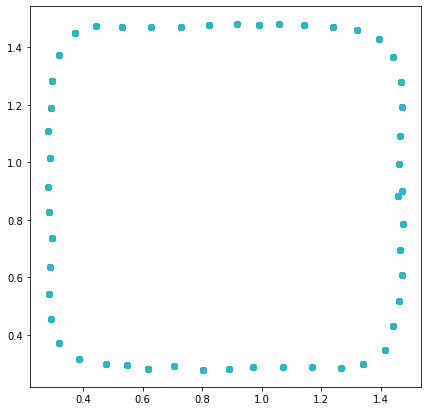

In [ ]:
study = optuna.create_study()
study.optimize(objective, n_trials=200)

In [ ]:
study.best_params

{'horizon_len': 9, 'delay': 1}

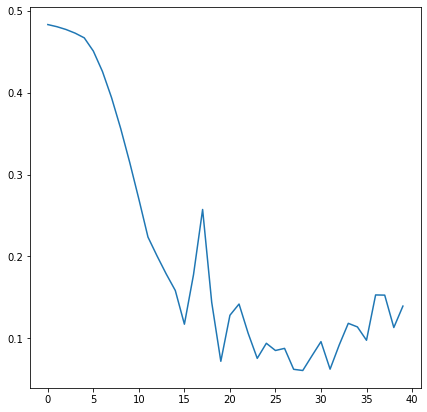

In [ ]:
plt.plot(loss_val)

In [ ]:
actions

[[0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 array([1., 1.]),
 array([1., 1.]),
 array([1., 1.]),
 array([1., 1.]),
 array([1., 1.]),
 array([1., 1.]),
 array([1., 1.]),
 array([1., 1.]),
 array([1., 1.]),
 array([1., 1.]),
 array([0.40619599, 1.        ]),
 array([0.53997948, 1.        ]),
 array([0.4439388, 1.       ]),
 array([0.45675287, 1.        ]),
 array([1., 1.]),
 array([-1.,  1.]),
 array([-1., -1.]),
 array([-0.65888825, -1.        ]),
 array([-0.42652097,  1.        ]),
 array([-1., -1.]),
 array([1.       , 0.2977749]),
 array([-1.,  1.]),
 array([-1.,  1.]),
 array([1., 1.]),
 array([-1., -1.]),
 array([1., 1.]),
 array([-1., -1.]),
 array([-1.        , -0.25072736]),
 array([1., 1.]),
 array([ 1., -1.]),
 array([-1.,  1.]),
 array([-1.,  1.]),
 array([ 1., -1.]),
 array([ 1., -1.]),
 array([-1., -1.]),
 array([1., 1.]),
 array([-1.        ,  0.18889156]),
 array([ 1., -1.]),
 array([1.        , 0.71122448]),
 array([1., 1.])